In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F

from IPython.display import clear_output


In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3060 Laptop GPU'

In [3]:
class CpRankEstimator(nn.Module):
    def __init__(self, n, d, cp_rank):
        super().__init__()
        self.d = d
        # self.a = nn.Parameter(torch.randn(cp_rank, n, 1, 1))
        # self.b = nn.Parameter(torch.randn(cp_rank, 1, n, 1))
        # self.c = nn.Parameter(torch.randn(cp_rank, 1, 1, n))
        dims = torch.eye(d, dtype=torch.long) * (n - 1) + torch.ones((d, d), dtype=torch.long)
        self.vectors = nn.ParameterList([nn.Parameter(torch.randn(cp_rank, *dims[i])) for i in range(d)])
        # torch.nn.parameter.Parameter(data=None, requires_grad=True)

    def forward(self, verbose=False):
        # t = self.a * self.b * self.c
        t = self.vectors[0]
        if verbose:
            print("t:", t)
        for i in range(1, self.d):
            if verbose:
                print("i:", i)
                print("svi:", self.vectors[i])
            t = t * self.vectors[i]
        
        # for i in range(n):
        #     for j in range(n):
        #         for k in range(n):
        #             # print("Ok!")
        #             assert self.a[i, 0, 0] * self.b[0, j, 0] * self.c[0, 0, k] == t[i, j, k]
        return t.sum(dim=0)

In [4]:
cp_rank = 2
n = 3
d = 3

model = CpRankEstimator(n, d, cp_rank)
model().shape

torch.Size([3, 3, 3])

In [5]:
np.tensordot(torch.randn(1, 2, 3), torch.randn(3, 4, 5), axes=1).shape

(1, 2, 4, 5)

In [6]:
def generate_random_tensor_from_M(n, d, tt_rank, seed=0):
    torch.manual_seed(seed)
    A = torch.randn(n, tt_rank)
    for _ in range(d - 2):
        A = np.tensordot(A, torch.randn(tt_rank, n, tt_rank), axes=1)
    return np.tensordot(A, torch.randn(tt_rank, n), axes=1)

In [13]:
generate_random_tensor_from_M(3, 3, 2).shape

(3, 3, 3)

In [254]:
def estimate_cp_rank(tensor, lr=3e-1, threshold=0.001, max_cp_rank=15, n_iters=500, draw_plot=False):
    d = len(tensor.shape)
    n = tensor.shape[0]
    threshold *= n ** (d // 2)
    print(f"n = {n}, d = {d}")
    assert tensor.shape == tuple([n] * d)
    frob_norms = []
    for cp_rank in range(1, max_cp_rank + 1):
        model = CpRankEstimator(n, d, cp_rank)
        
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        for _ in range(n_iters):
            optimizer.zero_grad()
            loss = ((model() - tensor) ** 2).sum()
            if torch.sqrt(loss).item() < threshold * cp_rank:
                break
            #print(loss)
            loss.backward()
            optimizer.step()
        frob_norms.append(torch.sqrt(loss).item())
        #print(loss)
    if draw_plot:
        plt.plot(np.arange(1, max_cp_rank + 1), frob_norms, label="Frobenius distance between tensor\nand low-rank approximation")
        #plt.axhline(y=threshold, color='r', linestyle='--', label=f"Threshold for negligible error = {threshold}")
        plt.plot(np.arange(1, max_cp_rank + 1), 
                 threshold * np.arange(1, max_cp_rank + 1), color='r', linestyle='--',
                 label=f"Threshold for negligible error = {threshold} * CP-rank")
        plt.xlabel("CP-rank")
        plt.legend()
    
    for i, frob_norm in enumerate(frob_norms):
        if frob_norm < threshold * (i + 1):
            return i + 1
    return np.inf

# Тестирование функции ``estimate_cp_rank`` на тензорах с известными CP-рангами

## Рассматриваем случай d = 2, то есть когда тензоры - матрицы, а CP-ранг - просто матричный ранг

In [255]:
def generate_random_matrix_with_fixed_cp_rank(n, cp_rank):
    ind = np.random.choice(n, n - cp_rank, replace=False)
    A = np.eye(n)
    for i in ind:
        A[i, i] = 0
    return A

In [256]:
generate_random_matrix_with_fixed_cp_rank(4, 2)

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [257]:
n = 5
cp_rank = 3
A = torch.tensor(generate_random_matrix_with_fixed_cp_rank(n, cp_rank))

In [258]:
A

tensor([[1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0.]], dtype=torch.float64)

n = 5, d = 2
Estimated CP-rank: 3


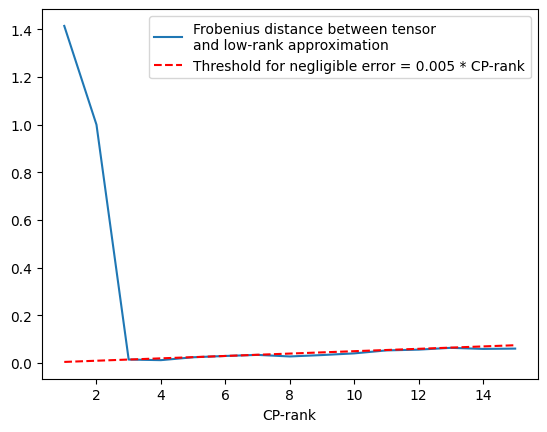

In [259]:
print("Estimated CP-rank: " + str(estimate_cp_rank(A, lr=6e-1, threshold=0.001, draw_plot=True)))

In [260]:
n = 25
cp_rank = 17
A = torch.tensor(generate_random_matrix_with_fixed_cp_rank(n, cp_rank))

n = 25, d = 2
Estimated CP-rank: 17


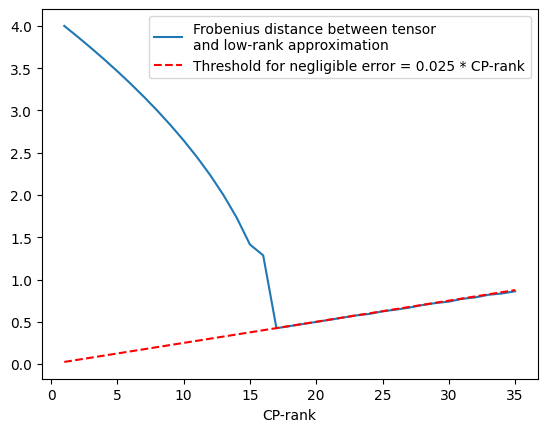

In [262]:
print("Estimated CP-rank: " + str(estimate_cp_rank(A, lr=2e-1, threshold=0.001, max_cp_rank=35, n_iters=1500, draw_plot=True)))

# Эксперименты на случайных тензорах из множества $M_{n, r}$ (d = 2)

In [263]:
# d = 2
# for q in range(1, 10):
#     n = q
#     tt_rank = q
#     A = torch.tensor(generate_random_tensor_with_fixed_tt_rank(n, d, tt_rank, seed=42))
#     print(estimate_cp_rank(A))

In [264]:
# d = 3
# for q in range(1, 10):
#     n = q
#     tt_rank = q
#     A = torch.tensor(generate_random_tensor_with_fixed_tt_rank(n, d, tt_rank, seed=42))
#     print(estimate_cp_rank(A, lr=1e-5, max_cp_rank=100))

In [265]:
import pandas as pd

In [266]:
q = 2
n = q
tt_rank = q + 1

In [267]:
results = pd.DataFrame(index=pd.Index(data=np.arange(2, 11), name="d"), columns=["Estimated CP-rank", "Theoretical lower bound on CP-rank"])
results["Theoretical lower bound on CP-rank"] = q ** (results.index // 2)

In [268]:
results

,Estimated CP-rank,Theoretical lower bound on CP-rank
d,,
2,NaN,2
3,NaN,2
4,NaN,4
5,NaN,4
6,NaN,8
7,NaN,8
8,NaN,16
9,NaN,16
10,NaN,32


In [269]:
def generate_random_tensor_from_M_eq(n, d, tt_rank, seed=0):
    torch.manual_seed(seed)
    A = torch.randn(n, tt_rank)
    core = torch.randn(tt_rank, n, tt_rank)
    for _ in range(d - 2):
        A = np.tensordot(A, core, axes=1)
    return np.tensordot(A, torch.randn(tt_rank, n), axes=1)

## d = 2

n = 2, d = 2
Estimated CP-rank: 2


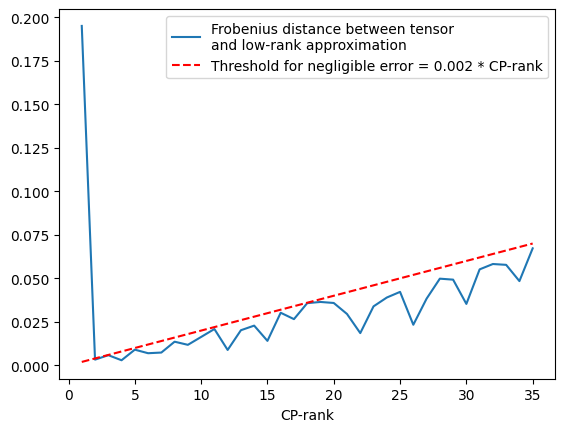

In [270]:
d = 2
A = torch.tensor(generate_random_tensor_from_M_eq(n, d, tt_rank, seed=42))
estimated_rank = estimate_cp_rank(A, lr=3e-1, max_cp_rank=35, draw_plot=True)
print("Estimated CP-rank: " + str(estimated_rank))

In [271]:
results.loc[d, "Estimated CP-rank"] = estimated_rank

## d = 3

n = 2, d = 3
Estimated CP-rank: 2


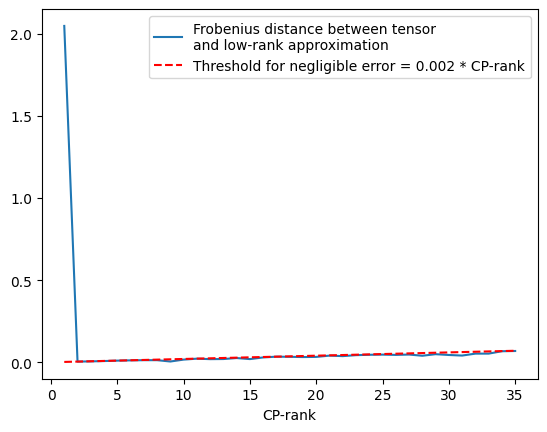

In [272]:
d = 3
A = torch.tensor(generate_random_tensor_from_M_eq(n, d, tt_rank, seed=42))
estimated_rank = estimate_cp_rank(A, lr=3e-1, max_cp_rank=35, n_iters=2000, draw_plot=True)
print("Estimated CP-rank: " + str(estimated_rank))

In [273]:
results.loc[d, "Estimated CP-rank"] = estimated_rank

## d = 4

n = 2, d = 4
Estimated CP-rank: 4


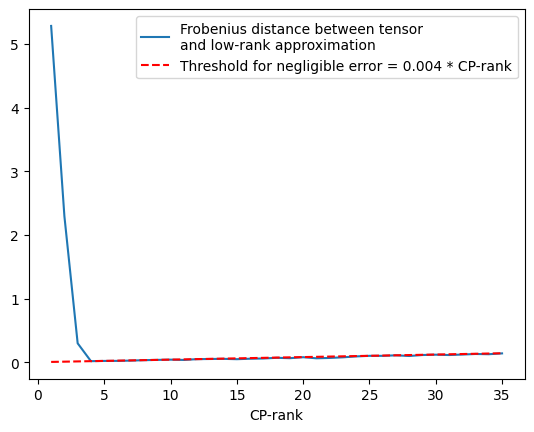

In [274]:
d = 4
A = torch.tensor(generate_random_tensor_from_M_eq(n, d, tt_rank, seed=42))
estimated_rank = estimate_cp_rank(A, lr=3e-1, max_cp_rank=35, n_iters=2000, draw_plot=True)
print("Estimated CP-rank: " + str(estimated_rank))

In [275]:
results.loc[d, "Estimated CP-rank"] = estimated_rank

## d = 5

n = 2, d = 5
Estimated CP-rank: 7


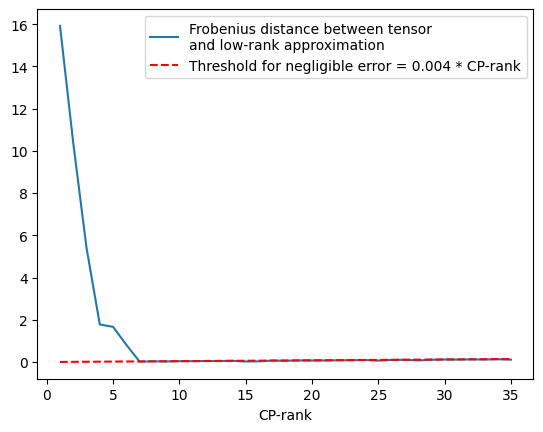

In [276]:
d = 5
A = torch.tensor(generate_random_tensor_from_M_eq(n, d, tt_rank, seed=42))
estimated_rank = estimate_cp_rank(A, lr=4e-1, max_cp_rank=35, n_iters=3000, draw_plot=True)
print("Estimated CP-rank: " + str(estimated_rank))

In [277]:
results.loc[d, "Estimated CP-rank"] = estimated_rank

## d = 6

n = 2, d = 6
Estimated CP-rank: 10


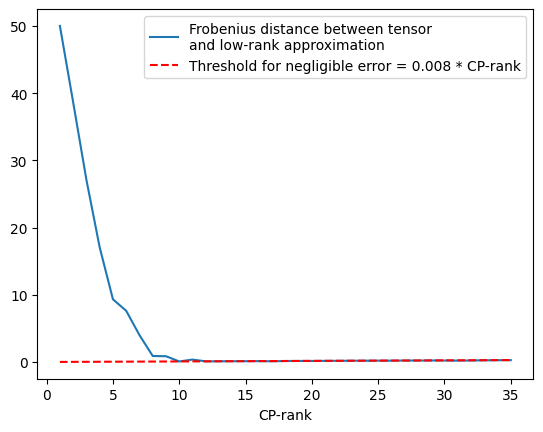

In [278]:
d = 6
A = torch.tensor(generate_random_tensor_from_M_eq(n, d, tt_rank, seed=42))
estimated_rank = estimate_cp_rank(A, lr=1.5e-1, max_cp_rank=35, n_iters=3500, draw_plot=True)
print("Estimated CP-rank: " + str(estimated_rank))

In [279]:
results.loc[d, "Estimated CP-rank"] = estimated_rank

## d = 7

n = 2, d = 7
Estimated CP-rank: 34


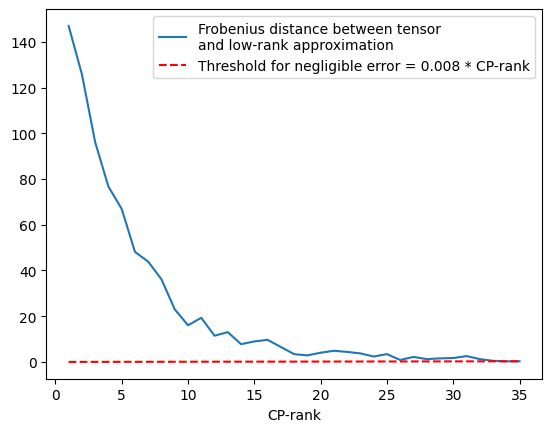

In [289]:
d = 7
A = torch.tensor(generate_random_tensor_from_M_eq(n, d, tt_rank, seed=42))
estimated_rank = estimate_cp_rank(A, lr=3e-3, max_cp_rank=35, n_iters=1500, draw_plot=True)
print("Estimated CP-rank: " + str(estimated_rank))

In [290]:
results.loc[d, "Estimated CP-rank"] = estimated_rank

## d = 8

n = 2, d = 8
Estimated CP-rank: 42


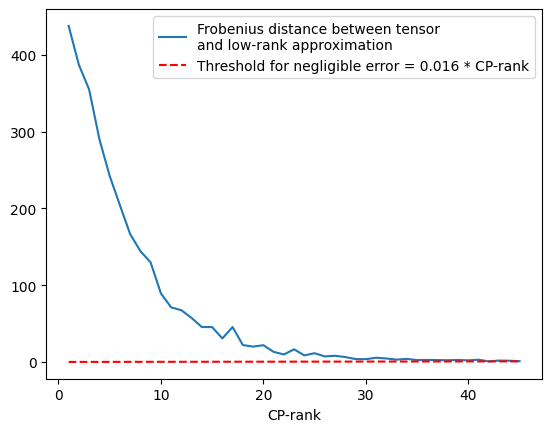

In [295]:
d = 8
A = torch.tensor(generate_random_tensor_from_M_eq(n, d, tt_rank, seed=42))
estimated_rank = estimate_cp_rank(A, lr=2.5e-3, max_cp_rank=45, n_iters=4000, draw_plot=True)
print("Estimated CP-rank: " + str(estimated_rank))

In [296]:
results.loc[d, "Estimated CP-rank"] = estimated_rank

In [297]:
results

,Estimated CP-rank,Theoretical lower bound on CP-rank
d,,
2,2,2
3,2,2
4,4,4
5,7,4
6,10,8
7,34,8
8,42,16
9,NaN,16
10,NaN,32


In [29]:
n = 2
tt_rank = 3

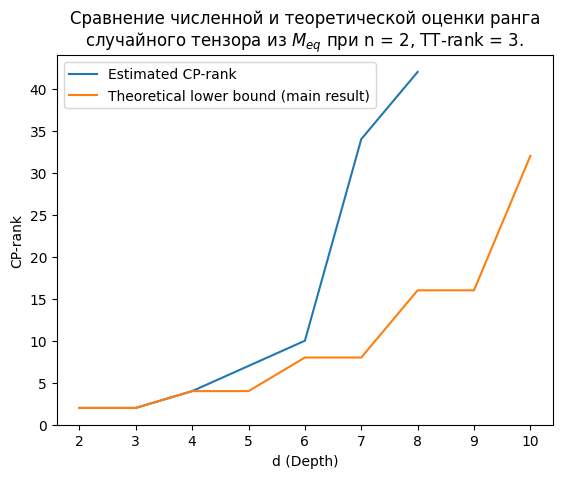

In [305]:
plt.title("Сравнение численной и теоретической оценки ранга\nслучайного тензора из $M_{eq}$ при n = 2, TT-rank = 3.")
plt.plot(results.index, results["Estimated CP-rank"], label="Estimated CP-rank")
plt.plot(results.index, results["Theoretical lower bound on CP-rank"], label="Theoretical lower bound (main result)")
# plt.axhline(y=threshold, color='r', linestyle='--', label=f"Threshold for negligible error = {threshold}")
plt.xlabel("d (Depth)")
plt.ylabel("CP-rank")
plt.legend()
plt.show()